In [1]:
import pandas 
import numpy as np
import os
import re
import operator
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from data import *
from constants import *
from models import *
from solver import *
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [18]:
root = "/mnt/raid/davech2y/3d_captioning/ShapeNetCore_vol/nrrd_256_filter_div_128_solid/"
captions = pandas.read_csv("captions.tablechair.csv").iloc[:4]
visual_contexts = np.load("data/visual_context.npy")
# captions = pandas.read_csv("captions.tablechair_prep.csv")

In [19]:
captions = Caption(captions)
captions.preprocess()
captions.tranform()
captions.sanity_check()

True

In [24]:
train_captions = captions.tranformed_csv.iloc[:2]
valid_captions = captions.tranformed_csv.iloc[2:4].reset_index(drop=True)

In [26]:
captions.preprocessed_csv.description.values.tolist()[:2]

['<START> the table is round and has 3 legs . the table is rotating <END>',
 '<START> the chair is made of plastic and has 4 legs , it is black in colour <END>']

In [28]:
captions.preprocessed_csv.description.values.tolist()[2:4]

['<START> it is narrow console table . it is made from plywood . its size is quite good to place anything on it . it is grey in colour .  <END>',
 '<START> a simple chair with wooden back rest and seating rest . the whole frame of the chair is powder coated stainless steel . it is brown and grey in colour .  <END>']

In [22]:
captions.dict_word2idx.__len__()

49

In [23]:
np.log(captions.dict_word2idx.__len__())

3.8918202981106265

In [9]:
###################################################################
#                                                                 #
#                                                                 #
#                  offline training for encoder                   #
#                                                                 #
#                                                                 #
###################################################################

# # prepare the dataloader
# shape_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
# shape_train_ds = ShapeDataset(root, train_captions, shape_transform)
# shape_train_dl = DataLoader(shape_train_ds, batch_size=10)
# shape_valid_ds = ShapeDataset(root, valid_captions, shape_transform)
# shape_valid_dl = DataLoader(shape_valid_ds, batch_size=10)
# shape_dl = {
#     'train': shape_train_dl,
#     'valid': shape_valid_dl
# }

# # load the pretrained encoder
# encoder = Encoder().cuda()
# optimizer = optim.SGD(encoder.parameters(), lr=0.01)
# criterion = nn.CrossEntropyLoss()
# encoder_solver = EncoderSolver(optimizer, criterion)

# # training
# encoder_solver.train(encoder, shape_dl, 10, 1)

In [10]:
# # plot the result
# epochs = len(encoder_solver.log.keys())
# train_losses = [encoder_solver.log[i]["train_loss"] for i in range(epochs)]
# valid_losses = [encoder_solver.log[i]["valid_loss"] for i in range(epochs)]

# fig = plt.gcf()
# fig.set_size_inches(12,8)
# plt.plot(range(1, epochs + 1), train_losses, label="train_loss")
# plt.plot(range(1, epochs + 1), valid_losses, label="valid_loss")
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.xticks(range(1, epochs + 1))
# plt.legend()
# plt.show()

# # save
# fig.savefig("data/encoder_curve.png")

In [11]:
###################################################################
#                                                                 #
#                                                                 #
#                  offline training for decoder                   #
#              (extracted visual contexts required)               #
#                                                                 #
###################################################################

# caption_train_ds = CaptionDataset(train_context, train_captions.description.values.tolist())
# caption_train_dl = DataLoader(caption_train_ds, batch_size=50, shuffle=False)
# caption_valid_ds = CaptionDataset(valid_context, valid_captions.description.values.tolist())
# caption_valid_dl = DataLoader(caption_valid_ds, batch_size=50, shuffle=False)
# caption_dl = {
#     "train": caption_train_dl,
#     "valid": caption_valid_dl
# }

# input_size = captions.dict_word2idx.__len__() + 1
# hidden_size = 512
# num_layer = 2

# decoder = Decoder(input_size, hidden_size, 2).cuda()
# decoder_solver = DecoderSolver(optim.RMSprop(decoder.parameters(), lr=0.001), nn.CrossEntropyLoss())

# decoder_solver.train(decoder, caption_dl, 10000, 1000)

In [29]:
###################################################################
#                                                                 #
#                                                                 #
#                   training for encoder-decoder                  #
#                                                                 #
#                                                                 #
###################################################################

# prepare the dataloader
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
train_ds = PipelineDataset(root, train_captions, transform)
train_dl = DataLoader(train_ds, batch_size=1)
valid_ds = PipelineDataset(root, valid_captions, transform)
valid_dl = DataLoader(valid_ds, batch_size=1)
dataloader = {
    'train': train_dl,
    'valid': valid_dl
}

# # load the pretrained encoder
# encoder = torch.load("data/encoder.pth").cuda()

# initialize the encoder
encoder = Encoder().cuda()

# define the decoder
input_size = captions.dict_word2idx.__len__() + 1
hidden_size = 512
num_layer = 2
decoder = Decoder(input_size, hidden_size, num_layer).cuda()

# prepare the training parameters
# optimizer = optim.Adam(list(decoder.parameters()) + list(encoder.fc_layer.parameters()), lr=0.001)
params = list(decoder.parameters()) + list(encoder.conv_layer.parameters()) + list(encoder.fc_layer.parameters())
optimizer = optim.Adam(params, lr=0.0001)
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
epoch = 500
verbose = 50

# training
encoder_decoder_solver = EncoderDecoderSolver(optimizer, criterion)
encoder_decoder_solver.train(encoder, decoder, dataloader, epoch, verbose)

[epoch 50/500] train_loss: 0.472014, valid_loss: 5.427614, ETA: 8m 1s
[epoch 100/500] train_loss: 0.096501, valid_loss: 5.962730, ETA: 2m 56s
[epoch 150/500] train_loss: 0.039450, valid_loss: 6.121402, ETA: 8m 50s
[epoch 200/500] train_loss: 0.021671, valid_loss: 6.243980, ETA: 4m 6s
[epoch 250/500] train_loss: 0.013884, valid_loss: 6.348452, ETA: 4m 51s
[epoch 300/500] train_loss: 0.009773, valid_loss: 6.440340, ETA: 4m 48s
[epoch 350/500] train_loss: 0.007302, valid_loss: 6.522576, ETA: 2m 15s
[epoch 400/500] train_loss: 0.005686, valid_loss: 6.595625, ETA: 2m 15s
[epoch 450/500] train_loss: 0.004564, valid_loss: 6.661470, ETA: 1m 11s
[epoch 500/500] train_loss: 0.003751, valid_loss: 6.721473, ETA: 0m 0s


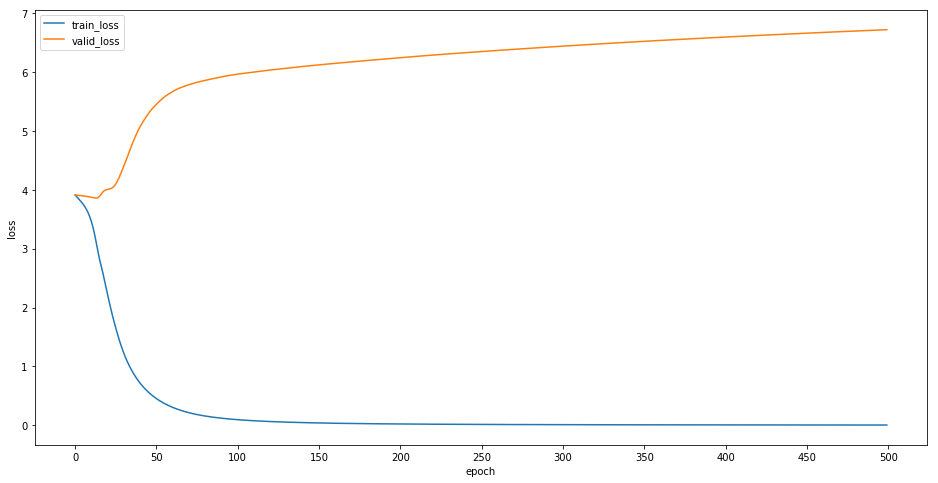

In [30]:
# plot the result
epochs = len(encoder_decoder_solver.log.keys())
train_losses = [encoder_decoder_solver.log[i]["train_loss"] for i in range(epochs)]
valid_losses = [encoder_decoder_solver.log[i]["valid_loss"] for i in range(epochs)]

fig = plt.gcf()
fig.set_size_inches(16,8)
plt.plot(range(epochs), train_losses, label="train_loss")
plt.plot(range(epochs), valid_losses, label="valid_loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xticks(range(0, epochs + 1, verbose))
plt.legend()
plt.show()

In [43]:
###################################################################
#                                                                 #
#                                                                 #
#       caption generating via encoder-decoder pipeline           #
#                                                                 #
#                                                                 #
###################################################################

# initialize the pipeline
encoder_path = "data/encoder_finetuned.pth"
decoder_path = "data/decoder_finetuned.pth"
encoder_decoder = Pipeline(encoder_path, decoder_path)

# prepare the dataloader
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])
train_ds = PipelineDataset(root, train_captions, transform)
dataloader = DataLoader(train_ds, batch_size=1)

# caption images
descriptions = []
for i, (image_inputs, caps, cap_lengths) in enumerate(dataloader):
    image_inputs = Variable(image_inputs).cuda()
    descriptions += encoder_decoder.generate_text(image_inputs, captions.dict_idx2word, 50)

In [44]:
descriptions

['<START> the chair is made of plastic and has 4 legs , it is black in colour <END>',
 '<START> the table is round and has 3 legs . the table is rotating <END>']